In [1]:
from brian2 import *
from brian2tools import brian_plot
prefs.codegen.target = 'numpy'
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False,
                     'lines.linewidth': 2, 'lines.markeredgewidth': 2})

## Synapses

In [2]:
# Modelling synaptic inputs in Brian
start_scope()

# Inputs
exc_inp = SpikeGeneratorGroup(1, [0, 0], [10, 50]*ms)
inh_inp = SpikeGeneratorGroup(1, [0, 0], [5, 55]*ms)

# Neuron
neurons = NeuronGroup(1, 'dv/dt = -v/(10*ms) : volt (unless refractory)',
                      threshold='v > 10*mV', reset='v = 0*mV', refractory=2*ms, method='exact')

# Synapses
exc_syn = Synapses(exc_inp, neurons, on_pre='v_post += 7*mV')  # on_pre means "on the arrival of pre-synaptic spike"
inh_syn = Synapses(inh_inp, neurons, on_pre='v_post -= 7*mV')
exc_syn.connect(); inh_syn.connect()

# Recordings
state_mon = StateMonitor(neurons, 'v', record=0)
spike_mon = SpikeMonitor(neurons)

run(100*ms)

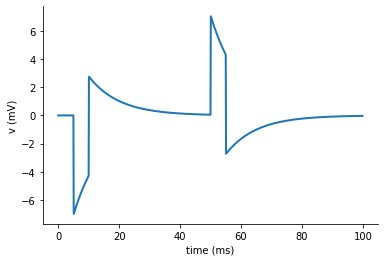

In [3]:
brian_plot(state_mon);

In [4]:
def simulate_synapses(exc_spikes, inh_spikes, synapses='delta'):
    start_scope()
    E_e = 70*mV; E_i = 0*mV
    if synapses == 'delta':
        eqs = "dv/dt = -v/(10*ms) : volt (unless refractory)"
        method = 'exact'
    elif synapses == 'current':
        eqs = '''dv/dt = (-v + I_e + I_i)/(10*ms) : volt (unless refractory)
                 dI_e/dt = -I_e/(5*ms) : volt
                 dI_i/dt = -I_i/(5*ms) : volt'''
        method = 'exact'
    elif synapses == 'conductance':
        eqs = '''dv/dt = (-v + g_e*(E_e - v) + g_i*(E_i - v))/(10*ms) : volt (unless refractory)
                 dg_e/dt = -g_e/(5*ms) : 1
                 dg_i/dt = -g_i/(5*ms) : 1'''
        method = 'euler'
    neurons = NeuronGroup(1, eqs, threshold='v > 10*mV',
                          reset='v = 0*mV', refractory=2*ms, method=method)
    exc_inp = SpikeGeneratorGroup(1, np.zeros(len(exc_spikes)), exc_spikes)
    inh_inp = SpikeGeneratorGroup(1, np.zeros(len(inh_spikes)), inh_spikes)
    if synapses == 'delta':
        exc_syn = Synapses(exc_inp, neurons, on_pre='v_post += 7*mV')
        inh_syn = Synapses(inh_inp, neurons, on_pre='v_post -= 7*mV')
    elif synapses == 'current':
        exc_syn = Synapses(exc_inp, neurons, on_pre='I_e += 25*mV')
        inh_syn = Synapses(inh_inp, neurons, on_pre='I_i -= 27*mV')
    elif synapses == 'conductance':
        exc_syn = Synapses(exc_inp, neurons, on_pre='g_e += 0.4')
        inh_syn = Synapses(inh_inp, neurons, on_pre='g_i += 1')
    exc_syn.connect(); inh_syn.connect()
    state_mon = StateMonitor(neurons, 'v', record=0)
    spike_mon = SpikeMonitor(neurons)
    run(200*ms)
    return state_mon.t, state_mon.v[0], spike_mon.t

def plot_synapses_sim(exc_spikes, inh_spikes, mon_t, mon_v, spikes):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 3),
                           gridspec_kw={'height_ratios': (1, 2, 1)})
    axs[0].eventplot(exc_spikes/ms, color='red')
    axs[0].axis('off')
    axs[1].plot(mon_t/ms, mon_v/mV, color='black')
    axs[1].vlines(spikes/ms, 10, 30, color='black')
    axs[1].axhline(color='gray', linestyle=':', zorder=-1)
    axs[1].axhline(10, color='gray', linestyle='--', zorder=-1)
    axs[1].set(xlabel='t (ms)', ylabel='v (mV)', ylim=(-10, 30))
    axs[2].eventplot(inh_spikes/ms, color='blue')
    axs[2].axis('off')

In [5]:
exc_spikes = [10, 50, 55, 100, 105, 150]*ms
inh_spikes = [75, 95, 150, 160]*ms
mon_t, mon_v, spikes = simulate_synapses(exc_spikes, inh_spikes, synapses='conductance')

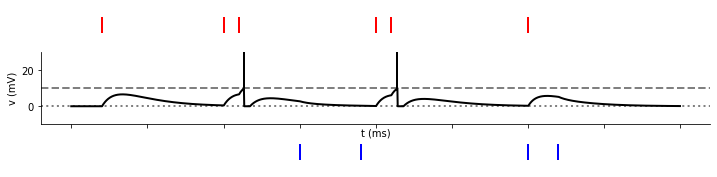

In [6]:
plot_synapses_sim(exc_spikes, inh_spikes, mon_t, mon_v, spikes)

## Randomly connected network

In [7]:
# Please ignore all the code for now, we'll play around with it first
def run_sim(g, nu_ext_relative, N_E=1000):
    start_scope()
    # network parameters
    gamma = 0.25
    N_I = int(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = C_ext = int(epsilon * N_E)
    C_I = int(epsilon * N_I)

    # neuron parameters
    tau = 20 * ms; theta = 20 * mV; V_r = 10 * mV; tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV; D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    neurons = NeuronGroup(N,"dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta", reset="v = V_r", refractory=tau_rp, method="exact")

    exc_neurons = neurons[:N_E]
    inh_neurons = neurons[N_E:]
    exc_synapses = Synapses(exc_neurons, neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(i='k for k in sample(N_E, size=C_E)')
    inhib_synapses = Synapses(inh_neurons, neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(i='k for k in sample(N_I, size=C_I)')

    nu_ext = nu_ext_relative * nu_thr
    external_poisson_input = PoissonInput(target=neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J)

    rate_monitor = PopulationRateMonitor(neurons)
    exc_monitor = SpikeMonitor(exc_neurons)
    inh_monitor = SpikeMonitor(inh_neurons[:50])  # record 50 inhibitory neurons
    state_monitor = StateMonitor(exc_neurons, 'v', record=0)  # record membrane potential of one neuron
    run(1*second, report='text')
    
    return {'rate_t': rate_monitor.t, 'rate': rate_monitor.rate,
            'exc_spikes_t': exc_monitor.t, 'exc_spikes_i': exc_monitor.i,
            'inh_spikes_t': inh_monitor.t, 'inh_spikes_i': inh_monitor.i,
            'state_t': state_monitor.t, 'state_v': state_monitor.v[0]}

In [8]:
def plot_results(results):
    fig, axs = plt.subplot_mosaic('''AC
                                     AF
                                     DG
                                     BH''', figsize=(10, 10), layout='constrained')
    axs['A'].plot(results['exc_spikes_t'][results['exc_spikes_i']<50]/ms,
                  results['exc_spikes_i'][results['exc_spikes_i']<50], '|')
    axs['A'].plot(results['inh_spikes_t']/ms,
                  -50 + results['inh_spikes_i'], '|', color='darkred')
    axs['A'].set(xlim=(800, 1000), xticks=[])
    axs['B'].plot(results['rate_t']/ms, results['rate']/Hz)
    axs['B'].set(xlim=(800, 1000), xlabel='t (ms)', ylabel='rate (1/second)')
    # Calculate CV and rate for 1000 neurons:
    CVs = np.empty(1000); rates = np.empty(1000)
    for idx in range(1000):
        if (any(results['exc_spikes_i'] == idx)):
            ISIs = np.diff(results['exc_spikes_t'][results['exc_spikes_i'] == idx]/ms)
            CVs[idx] = np.std(ISIs)/np.mean(ISIs)
            rates[idx] = 1000*1/np.mean(ISIs)  # rate estimated as inverse of mean ISI
        else:
            CVs[idx] = np.nan
            rates[idx] = np.nan
    # ISI distribution for neuron 0   
    ISIs = np.diff(results['exc_spikes_t'][results['exc_spikes_i'] == 0]/ms)
    axs['C'].hist(ISIs, bins=np.linspace(0, 50, 25))    
    axs['C'].text(0.95, 0.95,
                  f'firing rate: {rates[idx]:.1f}/s\nCV: {CVs[idx]:.2f}''',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['C'].transAxes)
    # Membrane potential for neuron 0
    axs['D'].plot(results['state_t']/ms, results['state_v']/mV)
    axs['D'].vlines(results['exc_spikes_t'][results['exc_spikes_i'] == 0]/ms, 20, 40)
    axs['D'].set(xlabel='t (ms)', ylabel='v (mV)', xlim=(800, 1000))
    # Rate distribution
    axs['F'].hist(rates, bins=np.linspace(0, 500, 50))
    axs['F'].text(0.95, 0.95, 'rate distribution',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['F'].transAxes)
    # CV distribution
    axs['G'].hist(CVs, bins=np.linspace(0, 1, 25))
    axs['G'].text(0.95, 0.95, 'CV distribution',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['G'].transAxes)
    # Autocorrelation of rate
    autocorr = np.correlate(results['rate'], results['rate'], mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr /= autocorr[0]
    axs['H'].plot(results['rate_t']/ms, autocorr)
    axs['H'].text(0.95, 0.95, 'rate autocorrelation',
                  horizontalalignment='right', verticalalignment='top',
                  transform=axs['H'].transAxes)
    axs['H'].set(xlabel='t (ms)', xlim=(0, 100), ylim=(0, 1))

In [9]:
results = run_sim(5, 2, N_E=10000)

Starting simulation at t=0. s for a duration of 1. s
285.1 ms (28%) simulated in 10s, estimated 25s remaining.
0.5632 s (56%) simulated in 20s, estimated 16s remaining.
0.8416 s (84%) simulated in 30s, estimated 6s remaining.
1. s (100%) simulated in 35s


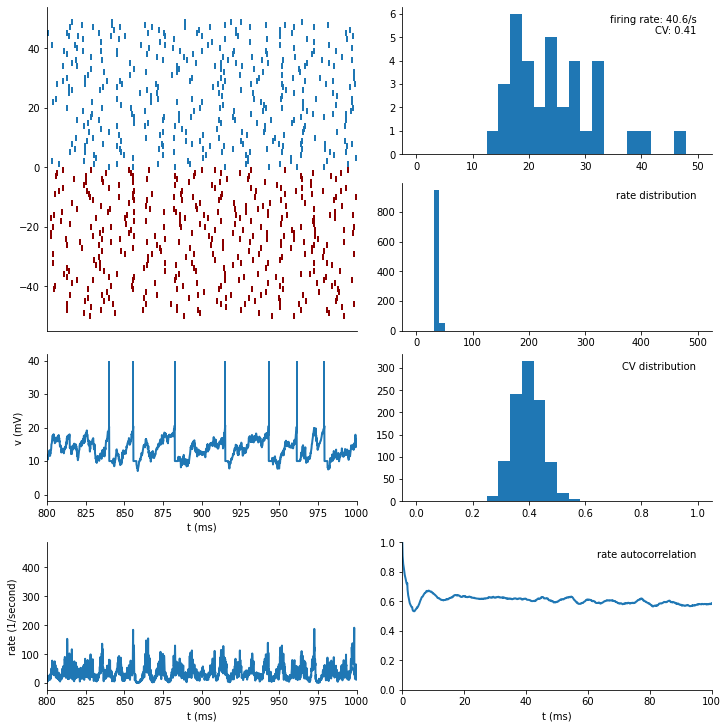

In [10]:
plot_results(results)